# Exploratory Data Analysis (EDA) of OpenML Datasets

This notebook presents an exploratory data analysis of datasets from OpenML. We will examine dataset descriptions, analyze word and sentence lengths, perform named entity recognition, POS tagging, and explore text similarity among dataset descriptions. We will also investigate the complexity of dataset descriptions, the distribution of tags, and the number of features in datasets. Finally, we will analyze the presence of URLs in dataset descriptions and explore the domains of these URLs.

In [53]:
import openml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import Counter
from tqdm import tqdm
import nltk
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud, STOPWORDS
from urlextract import URLExtract
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from spacy import displacy
import plotly.express as px
import textstat
from collections import defaultdict
from urllib.parse import urlparse

# Enable GPU support for spaCy
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# spacy must be imported after setting the environment variable
import spacy

activated = spacy.prefer_gpu()

try:
    nlp = spacy.load("en_core_web_trf")
except OSError:
    !python -m spacy download en_core_web_trf
    nlp = spacy.load("en_core_web_trf")

# Disable truncation in pandas display of columns
pd.set_option('display.max_colwidth', None)

# Disable truncation in pandas display of rows 
# pd.set_option('display.max_rows', None)

## Data Retrieval
Retrieving and listing all datasets from OpenML.

In [54]:
datasets = openml.datasets.list_datasets()
print(openml.datasets.list_datasets()[531])

ids = list(datasets.keys())
print("Number of datasets: ", len(ids))

# Removing non-dataset entries 
ids.remove(4537)
ids.remove(4546)
ids.remove(4562)

# Fetching datasets
datasets = openml.datasets.get_datasets(ids, download_data=False, download_qualities=False)
datasets[0]

/var/folders/cl/69z7wmcn5xx7cb7wc_xvd8fw0000gn/T/ipykernel_2905/2888816978.py:1: FutureWarning:

Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.

/var/folders/cl/69z7wmcn5xx7cb7wc_xvd8fw0000gn/T/ipykernel_2905/2888816978.py:2: FutureWarning:

Support for `output_format` of 'dict' will be removed in 0.15 and pandas dataframes will be returned instead. To ensure your code will continue to work, use `output_format`='dataframe'.



{'did': 531, 'name': 'boston', 'version': 1, 'uploader': '2', 'status': 'active', 'format': 'ARFF', 'MaxNominalAttDistinctValues': 9.0, 'NumberOfClasses': 0.0, 'NumberOfFeatures': 14.0, 'NumberOfInstances': 506.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 12.0, 'NumberOfSymbolicFeatures': 2.0}
Number of datasets:  5449


/Users/ivang/miniconda3/envs/openml-tags/lib/python3.11/site-packages/openml/datasets/functions.py:447: FutureWarning:

Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.



OpenML Dataset
Name.........: anneal
Version......: 1
Format.......: ARFF
Upload Date..: 2014-04-06 23:19:24
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/1666876/anneal.arff
OpenML URL...: https://www.openml.org/d/2
# of features: 39

## Initial Dataframe Creation
Creation of an initial dataframe for analysis, including URLs and descriptions.

In [55]:
df = pd.DataFrame([dataset.__dict__ for dataset in datasets])
# Add the OpenML URL to the dataframe
df['openml_url'] = [dataset.openml_url for dataset in datasets]
# All datasets which have None description, make it an empty string "
df['description'] = df['description'].fillna('')
# Remove datasets with identical descriptions
# df = df.drop_duplicates(subset='description')
df

ignore_attribute  dataset_id           name  version  \
0                None           2         anneal        1   
1                None           3       kr-vs-kp        1   
2                None           4          labor        1   
3                None           5     arrhythmia        1   
4                None           6         letter        1   
...               ...         ...            ...      ...   
5441             None       45932            RCM        2   
5442             None       45933  HousingPrices        1   
5443             None       45934  HousingPrices        2   
5444             None       45935     FX-CAD-USD        1   
5445             None       45936   IndoorScenes        2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5446 entries, 0 to 5445
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ignore_attribute          313 non-null    object
 1   dataset_id                5446 non-null   int64 
 2   name                      5446 non-null   object
 3   version                   5446 non-null   int64 
 4   description               5446 non-null   object
 5   cache_format              5446 non-null   object
 6   format                    5446 non-null   object
 7   creator                   3188 non-null   object
 8   contributor               752 non-null    object
 9   collection_date           3496 non-null   object
 10  upload_date               5446 non-null   object
 11  language                  1821 non-null   object
 12  licence                   5446 non-null   object
 13  url                       5446 non-null   object
 14  default_target_attribute

## Description Length Analysis

Analyzing the length of dataset descriptions.

<Axes: >

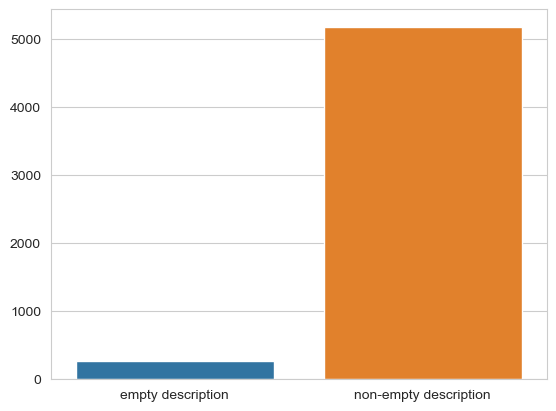

In [57]:
sns.barplot(x=['empty description', 'non-empty description'],
            y=[len(df[df['description'] == '']), len(df[df['description'] != ''])],
            hue=['empty description', 'non-empty description'])

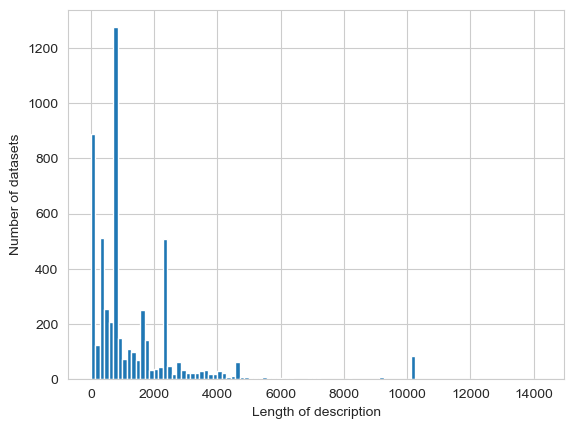

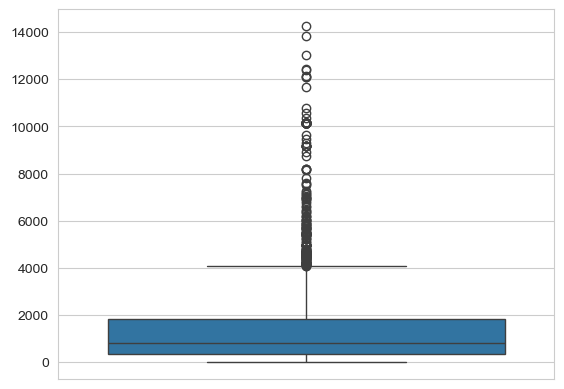

In [58]:
plt.hist([len(d) for d in df['description']], bins=100, color='C0')
plt.xlabel('Length of description')
plt.ylabel('Number of datasets')
plt.show()

sns.boxplot([len(d) for d in df['description']], color='C0')
plt.show()

## Filtering Long Descriptions

Filtering out datasets with unusually long descriptions for further inspection.

In [59]:
df[df['description'].map(len) > 9000]

ignore_attribute  dataset_id  \
41               None          49   
43               None          51   
139              None         204   
163              None         231   
383         [country]         528   
...               ...         ...   
5265             None       45532   
5266             None       45533   
5267             None       45534   
5268             None       45535   
5287             None       45562   

                                                         name  version  \
41                                                    heart-c        1   
43                                                    heart-h        1   
139                                               cholesterol        1   
163                                                 hungarian        1   
383                                                humandevel        1   
...                                                       ...      ...   
5265  timing-attack-dataset-35-micro-seconds-delay-2022-09-18        1   
5266  timing-attack-dataset-35-micro-seconds-delay-2022-09-19        1   
5267  timing-attack-dataset-35-micro-seconds-delay-2022-09-20        1   
5268  timing-attack-dataset-35-micro-seconds-delay-2022-09-21        1   
5287                                            seismic-bumps        3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## Word and Sentence Analysis

Analyzing the word count and average sentence length in dataset descriptions.

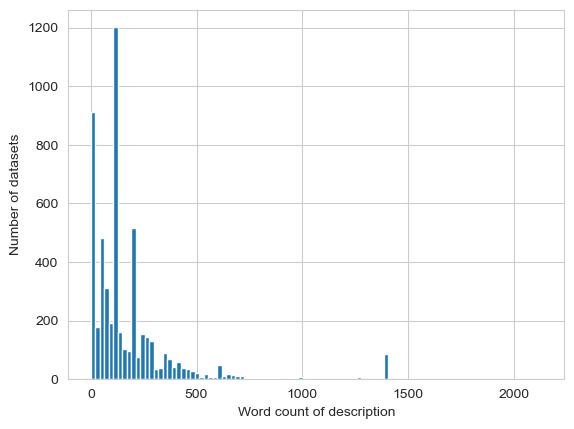

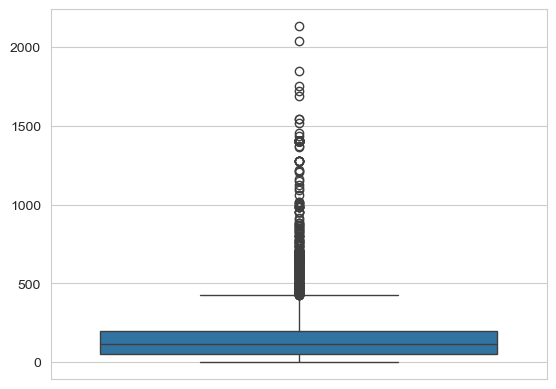

In [60]:
# Word count analysis
plt.hist([len(d.split()) for d in df['description']], bins=100, color='C0')
plt.xlabel('Word count of description')
plt.ylabel('Number of datasets')
plt.show()

sns.boxplot([len(d.split()) for d in df['description']], color='C0')
plt.show()

[nltk_data] Downloading package punkt to /Users/ivang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


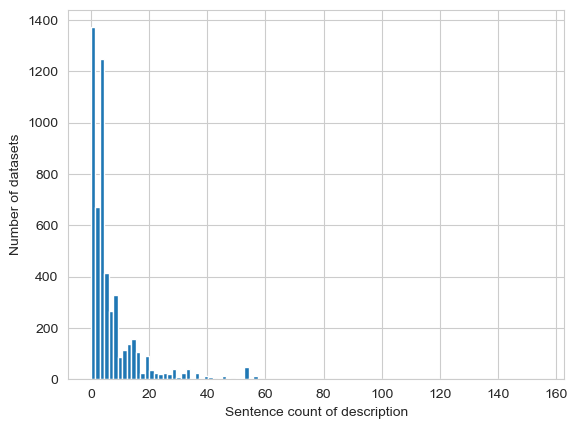

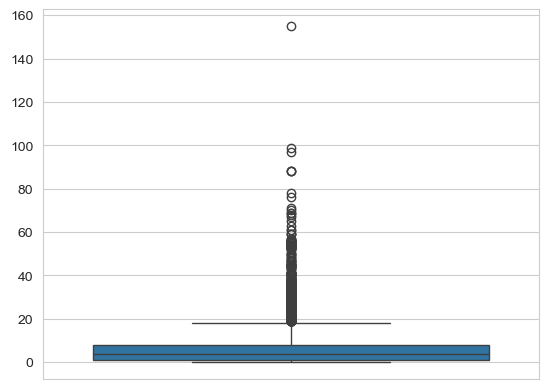

In [61]:
# Sentence length analysis 
import nltk
from nltk import tokenize

nltk.download('punkt')

plt.hist([len(tokenize.sent_tokenize(d)) for d in df['description']], bins=100, color='C0')
plt.xlabel('Sentence count of description')
plt.ylabel('Number of datasets')
plt.show()

sns.boxplot([len(tokenize.sent_tokenize(d)) for d in df['description']], color='C0')
plt.show()

## Mean Word Length Calculation

Computing the mean word length in dataset descriptions using spaCy for more accurate tokenization.

In [ ]:
# Function to calculate mean word length
def mean_word_length(description):
    doc = nlp(description)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    if words:  # Check if there are words to avoid ZeroDivisionError
        return sum(len(word) for word in words) / len(words)
    else:
        return 0


mean_word_lengths = df['description'].apply(mean_word_length)
print("Mean word lengths mean and median: ", mean_word_lengths.mean(), mean_word_lengths.median())

Average word length in English texts is 5.1 characters


## Visualization of Mean Word Lengths

Displaying the distribution of mean word lengths across dataset descriptions.

In [ ]:
plt.hist(mean_word_lengths, bins=100, color='C0', range=(0, 12))
plt.xlabel('Mean word length of description')
plt.ylabel('Number of datasets')
plt.show()

## Longest Word in Descriptions

Identifying the longest words within dataset descriptions.

In [ ]:
def longest_word(description):
    doc = nlp(description)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    if words:  # Check if there are words to avoid ZeroDivisionError
        return max(words, key=len)
    else:
        return None


longest_words = df['description'].apply(longest_word)
longest_words.value_counts().head(10)

## Term Frequency Analysis

Performing term frequency analysis to identify the most common words and phrases in dataset descriptions, excluding common stopwords.

In [ ]:
nltk.download('stopwords')

# Function to clean and preprocess text
def clean(text, remove_stopwords=True, remove_numbers=True):
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    # Remove stopwords
    if remove_stopwords:
        text = ' '.join([word for word in word_tokenize(text) if word not in stopwords.words('english')])
    # Remove numbers too
    if remove_numbers:
        text = re.sub(r'\d+', '', text)

    return text

# Term frequency analysis for single words
mostCommon = Counter(word_tokenize(" ".join(df['description'].map(clean)))).most_common(15)
words = [word[0] for word in mostCommon]
frequency = [word[1] for word in mostCommon]

sns.barplot(x=frequency, y=words, hue=words)
plt.show()

## Topics Bar Chart
![Topics Bar Chart](latex/proposal/images/topics_barchart.png)

## Bigram Frequency Analysis

Analyzing the frequency of bigrams (pairs of words) in dataset descriptions.

In [ ]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(df['description'].map(clean))

count_values = bigrams.toarray().sum(axis=0)
bigram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
bigram_freq.columns = ["frequency", "bigram"]

sns.barplot(x=bigram_freq['frequency'][:15], y=bigram_freq['bigram'][:15], hue=bigram_freq['bigram'][:15])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Datasets Containing Specific Keywords

Filtering datasets that contain specific keywords such as 'TCP' within their descriptions.

In [ ]:
df[df['description'].map(lambda x: 'tcp' in x)].head(50)

## Trigram Frequency Analysis

Similar to bigram analysis, examining the frequency of trigrams (three-word sequences).

In [ ]:
cv = CountVectorizer(ngram_range=(3, 3))
trigrams = cv.fit_transform(df['description'].map(clean))

count_values = trigrams.toarray().sum(axis=0)
trigram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
trigram_freq.columns = ["frequency", "trigram"]

sns.barplot(x=trigram_freq['frequency'][:15], y=trigram_freq['trigram'][:15], hue=trigram_freq['trigram'][:15])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

## Exploring Original Data URLs

Investigating the presence and domains of original data URLs in the dataset descriptions.

In [ ]:
# Counting datasets with original data URLs
len(df[df['original_data_url'].notnull()])

# Visualization of datasets with and without original data URLs
sns.barplot(x=['original_data_url', 'no original_data_url'],
            y=[len(df[df['original_data_url'].notnull()]), len(df[df['original_data_url'].isnull()])],
            hue=['original_data_url', 'no original_data_url'])
plt.show()


## Domain Analysis of URLs

Analyzing the domains of URLs found in the descriptions and visualizing the top domains.

In [ ]:
domains = (df['original_data_url'].dropna().map(lambda x: urlparse(x).netloc))

k = 15
sns.barplot(x=domains.value_counts().head(k), y=domains.value_counts().head(k).index,
            hue=domains.value_counts().head(k).index)
plt.show()


## Filtering Datasets by Domain

Filtering datasets with URLs from specific domains such as 'ebi.ac.uk' and 'github'.

In [ ]:
df[df['original_data_url'].map(lambda x: 'ebi.ac.uk' in x if x else False)][
    ['name', 'original_data_url', 'openml_url']]

In [ ]:
df[df['original_data_url'].map(lambda x: 'lib.stat.cmu' in x if x else False)][['name', 'original_data_url', 'openml_url']]

In [ ]:
df[df['original_data_url'].map(lambda x: 'github' in x if x else False)][['name', 'original_data_url', 'openml_url']]


## Latent Dirichlet Allocation (LDA) for Topic Modeling

Using LDA to model topics in dataset descriptions and visualizing with pyLDAvis.


In [ ]:
nltk.download('wordnet')
nltk.download('punkt')

def preprocess(df):
    corpus = []
    lem = WordNetLemmatizer()
    for description in df['description']:
        description = description.lower()
        words = [w for w in word_tokenize(description) if (w not in stopwords.words('english'))]
        words = [lem.lemmatize(w) for w in words if len(w) > 2]

        corpus.append(words)

    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    return corpus, dic, bow_corpus


corpus, dic, bow_corpus = preprocess(df)
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=50,
                                       id2word=dic,
                                       passes=10,
                                       workers=2)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

## Wordcloud

Creating a word cloud to visualize the most common words in dataset descriptions.

In [ ]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        collocations=False,
        random_state=1)

    wordcloud = wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Named Entity Recognition (NER) with spaCy

Analyzing named entities in dataset descriptions to identify common entities like organizations, locations, dates, etc.

In [ ]:
# Get the EntityRecognizer component from the pipeline
ner = nlp.get_pipe("ner")

# List the available entity types
entity_labels = ner.labels

print(entity_labels)

# Description for each entity type
for entity in entity_labels:
    print(f"{entity}: {spacy.explain(entity)}")

### Visualization of Named Entities

Visualizing named entities in a sample dataset description.


In [ ]:
# Example visualization of entities in the description of the 500th dataset
doc = nlp(df['description'][500])

# Print detected entities
print(doc.ents)

# Visualize the entities
displacy.render(doc, style="ent")

### Named Entity Frequency Analysis

Counting the frequency of each entity type across all dataset descriptions.

In [ ]:
# Perform NER on all descriptions
docs = [nlp(description) for description in tqdm(df['description'])]

# Count all named entities
entity_freq_counter = Counter([X.label_ for doc in docs for X in doc.ents])
entity_freq = entity_freq_counter.most_common()

# Plotting entity frequencies using Plotly
labels, values = zip(*entity_freq[::-1])  # Reverse for descending order in plot
entity_explanations = [spacy.explain(label) for label in labels]

# Generate the Plotly bar chart
fig = px.bar(x=values, y=labels, orientation='h', labels={'x': 'Count', 'y': 'Entity'},
             hover_data={'Entity': labels, 'Count': values, 'Description': entity_explanations})
fig.update_traces(hovertemplate='<b>Entity:</b> %{y}<br><b>Count:</b> %{x}<br><b>Description:</b> %{customdata[2]}')
fig.show()

### Exploration of Most Common Entities

Investigating the most common entities for each entity type.

In [ ]:
# Function to get the most common entities for a given label
def get_entities(label, most_common=10):
    entities = [X.text for doc in docs for X in doc.ents if X.label_ == label]
    return Counter(entities).most_common(most_common)

# Function to plot the most common entities for a given label
def plot_entities(label, k=15):
    entities = get_entities(label, k)
    entity_labels, entity_counts = zip(*entities)
    sns.barplot(x=list(entity_counts), y=list(entity_labels))
    plt.title(f'Top {k} most common entities for {label}')
    plt.show()

# Plot the most common entities for each label
for label in entity_labels:
    plot_entities(label)


## Part of Speech (POS) Tagging with spaCy

Analyzing the parts of speech in dataset descriptions to understand their grammatical composition.

In [ ]:
# Example visualization of POS tags in the description of the 500th dataset 
doc = nlp(df['description'][500][:400])

options = {'distance': 75, 'compact': True, 'color': 'black', 'bg': '#f9e79f'}

# Visualize the entities
displacy.render(doc, style="dep", jupyter=True, options=options)

In [ ]:
# Example POS tagging with explanations
for token in nlp('Can you give me the can, please?'):
    print(token.text, token.pos_, token.tag_, spacy.explain(token.tag_))

# Aggregate POS tagging for all descriptions
pos_freq_counter = Counter([X.pos_ for doc in docs for X in doc])
pos_freq = pos_freq_counter.most_common()

# Plotting POS frequencies using Plotly
labels, values = zip(*pos_freq[::-1])  # Reverse for descending order in plot
pos_explanations = [spacy.explain(label) for label in labels]

# Generate the Plotly bar chart
fig = px.bar(x=values, y=labels, orientation='h', labels={'x': 'Count', 'y': 'POS'},
             hover_data={'POS': labels, 'Count': values, 'Description': pos_explanations})
fig.update_traces(hovertemplate='<b>POS:</b> %{y}<br><b>Count:</b> %{x}<br><b>Description:</b> %{customdata[2]}')
fig.show()


## Assessing Dataset Description Complexity

Evaluating the readability of dataset descriptions using the Flesch reading ease score.


### Readability Score Interpretation

The Flesch reading ease score is interpreted as follows:
- 90-100: Very easy to read, understood by an average 11-year-old student
- 80-90: Easy to read, conversational English for consumers
- 70-80: Fairly easy to read
- 60-70: Plain English, easily understood by 13- to 15-year-old students
- 50-60: Fairly difficult to read
- 30-50: Difficult to read
- 0-30: Very difficult to read, best understood by university graduates

In [ ]:
# Apply the Flesch reading ease test to each description, filter the ones with score below 0
stat = df['description'].apply(
    lambda x: textstat.textstat.flesch_reading_ease(x) if 0 < textstat.textstat.flesch_reading_ease(x) <= 100 else None)
stat.hist()

## Exploratory Data Analysis on Tags

We perform EDA on the 'tag' feature of datasets to better understand their categorization.


### Tag Presence Analysis

Comparing the number of datasets with and without tags.

In [ ]:
# Count datasets with and without tags
datasets_with_tags = df[df['tag'].notnull()]
datasets_without_tags = df[df['tag'].isnull()]

sns.barplot(x=['datasets with tags', 'datasets without tags'],
            y=[len(datasets_with_tags), len(datasets_without_tags)],
            hue=['datasets with tags', 'datasets without tags'])
plt.show()

### Tag Distribution Analysis

Analyzing the distribution of tags across datasets.

In [ ]:
print(f"Average number of tags per dataset: {df['tag'].map(lambda x: len(x) if x else 0).mean()}")

In [ ]:
plt.hist(df['tag'].map(lambda x: len(x) if x else 0), bins=np.arange(0, 10) - 0.5)
plt.xlabel('Number of Tags')
plt.ylabel('Number of Datasets')
plt.xticks(range(10))
plt.show()

### Most Common Tags

Identifying the most common tags across all datasets.

In [ ]:
tags = df['tag'].dropna().map(lambda x: x if isinstance(x, list) else [x])
tags = [tag for sublist in tags for tag in sublist]
tag_freq = Counter(tags)
tag_freq = pd.DataFrame(sorted([(count, tag) for tag, count in tag_freq.items()], reverse=True))
tag_freq.columns = ['frequency', 'tag']

k = 30
sns.barplot(x=tag_freq['frequency'][:k], y=tag_freq['tag'][:k], hue=tag_freq['tag'][:k])
plt.title(f'Top {k} most common tags')
plt.show()

## Text Similarity Analysis

We analyze the similarity between dataset descriptions using TF-IDF and cosine similarity.


### Cosine Similarity Matrix

Generating a cosine similarity matrix for the dataset descriptions.

In [ ]:
# Vectorize the descriptions
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['description'].map(clean))

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

# Plot the similarity matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cosine_sim, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False)
plt.show()

### Distribution of Cosine Similarities

Examining the distribution of similarity scores between different dataset descriptions.

In [ ]:
# Extract the upper triangle of the matrix, excluding the diagonal
upper_tri_idx = np.triu_indices_from(cosine_sim, k=1)
unique_similarities = cosine_sim[upper_tri_idx]

plt.figure(figsize=(10, 5))
plt.hist(unique_similarities, bins=100)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

### Similar Dataset Pairs

Filtering dataset pairs with a high level of similarity (cosine similarity > 0.9).

In [ ]:
sns.barplot(x=['below 0.9', 'above 0.9'],
            y=[len(np.where(np.triu(cosine_sim, k=1) < 0.9)[0]), len(np.where(np.triu(cosine_sim, k=1) > 0.9)[0])],
            hue=['below 0.9', 'above 0.9'])
plt.show()

In [ ]:
above_threshold_indices = np.where(np.triu(cosine_sim, k=1) > 0.9)

# Extract the dataset pairs based on the indices
similar_pairs = [(i, j, cosine_sim[i, j]) for i, j in zip(*above_threshold_indices)]

# Create a new DataFrame to store the similar dataset pairs with their similarity score
similar_df = pd.DataFrame(similar_pairs, columns=['Dataset_ID_1', 'Dataset_ID_2', 'Similarity'])

# Add dataset names, descriptions, openml_url, and version to the DataFrame for easier interpretation
similar_df['Dataset_Name_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['name'])
similar_df['Dataset_Description_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['description'])
similar_df['OpenML_URL_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['openml_url'])
similar_df['Version_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['version'])

similar_df['Dataset_Name_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['name'])
similar_df['Dataset_Description_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['description'])
similar_df['OpenML_URL_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['openml_url'])
similar_df['Version_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['version'])

similar_df

In [ ]:
# Show an example of dataset pairs with high similarity 
similar_df[similar_df['Dataset_ID_1'] == 1287]

## Comparing Versions of Datasets

Investigating how dataset descriptions vary across different versions of the same dataset.

### Analysis of Similarity Between Different Dataset Versions

In [ ]:
# Filter the similar_df for entries with the same name and different version (as before)
same_name_different_version = similar_df[
    (similar_df['Dataset_Name_1'] == similar_df['Dataset_Name_2']) &
    (similar_df['Version_1'] != similar_df['Version_2'])
    ]

# Filter the similar_df for entries that are not the same dataset (the complement)
not_same_dataset = similar_df[
    (similar_df['Dataset_Name_1'] != similar_df['Dataset_Name_2'])
]

In [ ]:
same_name_different_version

In [ ]:
not_same_dataset

### Visualizing Similarity Distribution for Different Versions

In [ ]:
name_to_indices = defaultdict(list)
for i, row in df.iterrows():
    name_to_indices[row['name']].append(i)

version_similarity = []

for name, indices in name_to_indices.items():
    # Only consider names with more than one version
    if len(indices) > 1:
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                idx1, idx2 = indices[i], indices[j]
                similarity = cosine_sim[idx1, idx2]
                version_similarity.append({
                    'Dataset_Name': name,
                    'Version_1': df.iloc[idx1]['version'],
                    'OpenML_URL_1': df.iloc[idx1]['openml_url'],
                    'Version_2': df.iloc[idx2]['version'],
                    'OpenML_URL_2': df.iloc[idx2]['openml_url'],
                    'Similarity': similarity
                })

version_similarity_df = pd.DataFrame(version_similarity)

version_similarity_sorted = version_similarity_df.sort_values(by=['Dataset_Name', 'Similarity'],
                                                              ascending=[True, False])
plt.figure(figsize=(10, 5))
plt.hist(version_similarity_sorted['Similarity'], bins=100)

plt.title('Distribution of Cosine Similarities for Different Versions of the Same Dataset')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.show()

### Most Similar Dataset Versions

Identifying the most similar versions of datasets based on cosine similarity.

In [ ]:
# Group by the 'name' column and count the number of versions for each dataset
version_counts = df.groupby('name').size()

# We're interested in datasets that have more than one version
multiple_versions = version_counts[version_counts > 1]

num_bins = min(multiple_versions.nunique(), 50)

plt.figure(figsize=(12, 6))
plt.hist(multiple_versions, bins=np.arange(1, num_bins + 1) - 0.5)

plt.title('Distribution of Number of Versions per Dataset')
plt.xlabel('Number of Versions')
plt.ylabel('Number of Datasets')

plt.xticks(range(1, num_bins + 1))
plt.show()

## Exploratory Data Analysis on Dataset Features

Analyzing the features of the datasets such as the number of features and their types.

### Distribution of Number of Features

In [ ]:
num_features = df._features.map(len)
plt.hist(num_features[num_features < 1000], bins=100, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

### Distribution of Number of Features with feature count > 1000 and > 2000

In [ ]:
plt.hist(num_features[(num_features > 1000) & (num_features < 2000)], bins=10, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

plt.hist(num_features[(num_features > 2000)], bins=10, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

## Dataset Tags Analysis

Exploring the tags associated with the datasets to understand their categorization.

### POS Tagging and NER on Tags

In [ ]:
# Combine all tags into one list and then into a text string for processing
tags = df['tag'].dropna().tolist()
tags_combined = ' '.join([' '.join(tag_list) for tag_list in tags if isinstance(tag_list, list)])

doc_tags = nlp(tags_combined)

# POS Tagging
pos_counts = Counter([token.pos_ for token in doc_tags])

# NER
ner_counts = Counter([ent.label_ for ent in doc_tags.ents])

# Convert the counts to DataFrames for easy plotting
df_pos_counts = pd.DataFrame(pos_counts.items(), columns=['POS', 'Frequency']).sort_values(by='Frequency',
                                                                                           ascending=True)
df_ner_counts = pd.DataFrame(ner_counts.items(), columns=['Entity', 'Frequency']).sort_values(by='Frequency',
                                                                                              ascending=True)

# Plotting POS tags using Plotly
fig_pos = px.bar(df_pos_counts, x='Frequency', y='POS', orientation='h', title='Frequency of POS Tags in Dataset Tags')
fig_pos.update_layout(xaxis_title='Frequency', yaxis_title='POS')
fig_pos.show()

# Plotting NER tags using Plotly
fig_ner = px.bar(df_ner_counts, x='Frequency', y='Entity', orientation='h',
                 title='Frequency of Named Entities in Dataset Tags')
fig_ner.update_layout(xaxis_title='Frequency', yaxis_title='Entity')
fig_ner.show()

## URL Analysis in Dataset Descriptions

Identifying and analyzing the presence of URLs in the dataset descriptions.

### Datasets with URLs

In [ ]:
# Function to check if a description contains a URL
def contains_url(description):
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    return bool(urls)

# Apply the function to each description and create a new column 'has_url'
# df['has_url'] = df['description'].fillna('').apply(contains_url)
# 
# # Filter the DataFrame to only include rows where 'has_url' is True
# datasets_with_urls = df[df['has_url']]
# 
# # Display these datasets
# datasets_with_urls

# same but without the 'has_url' column
datasets_with_urls = df[df['description'].apply(contains_url)]
datasets_with_urls

### Visualization of Datasets with URLs vs Datasets without URLs 

In [ ]:
sns.barplot(x=['datasets with urls', 'datasets without urls'],
            y=[len(datasets_with_urls), len(df) - len(datasets_with_urls)],
            hue=['datasets with urls', 'datasets without urls'])

### Number of URLs in Dataset Descriptions

In [ ]:
# Plot the number of URLs in dataset descriptions for all datasets
plt.hist(df['description'].apply(lambda x: len(URLExtract().find_urls(x))), bins=100, color='C0')
plt.xlabel('Number of URLs in description')
plt.ylabel('Number of datasets')
plt.show()

# Plot the number of URLs in dataset descriptions for datasets with URLs
plt.hist(datasets_with_urls['description'].apply(lambda x: len(URLExtract().find_urls(x))), bins=100, color='C0')
plt.xlabel('Number of URLs in description')
plt.ylabel('Number of datasets')
plt.show()

In [ ]:
def extract_domain(description):
    # Find all URLs in the description
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    domains = []
    for url in urls:
        # Prepend a scheme if missing
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url
        try:
            domain = urlparse(url).netloc
            if domain:
                domains.append(domain)
            else:
                print(f"Error: No domain found in URL: {url}")
        except ValueError as e:
            # If an invalid URL is found, log an error message
            print(f"ValueError: {str(e)} in URL: {url}")
    return domains

domains = datasets_with_urls['description'].apply(extract_domain)
domains

### Distribution of Domains

In [ ]:
# Plot distribution of domains
sublists = [domain for sublist in domains for domain in sublist]
domain_freq = Counter(sublists)
domain_freq = pd.DataFrame(sorted([(count, domain) for domain, count in domain_freq.items()], reverse=True))
domain_freq.columns = ['frequency', 'domain']

k = 15
sns.barplot(x=domain_freq['frequency'][:k], y=domain_freq['domain'][:k], hue=domain_freq['domain'][:k])
plt.title(f'Top {k} most common domains in dataset descriptions')
plt.show()